# Name: Saran Adhikari

# University ID: 2329794


# A Text Classification with Recurrent Neural Network and It’s Variant.

In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Text Preprocessing, Tokenization and Padding

In [ ]:
!pip uninstall -y numpy
!pip install numpy

Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Successfully uninstalled numpy-1.23.5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 114.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.5 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import tensorflow as tf
from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/AI&ML/COURSEWORK02/hatevsoffensive_language.csv")

In [ ]:
df.head()

,label,text
0,neither,!!! RT @mayasolovely: As a woman you shouldn't...
1,offensive language,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,offensive language,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,offensive language,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,offensive language,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#','', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(rf'[{string.punctuation}]', '', text)
    return text

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = clean_text(text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['clean_text'] = df['text'].apply(preprocess)
df.head()

,label,text,clean_text
0,neither,!!! RT @mayasolovely: As a woman you shouldn't...,rt woman shouldnt complain cleaning house amp ...
1,offensive language,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,rt boy dat coldtyga dwn bad cuffin dat hoe st ...
2,offensive language,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,rt dawg rt ever fuck bitch start cry confused ...
3,offensive language,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,rt look like tranny
4,offensive language,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,rt shit hear might true might faker bitch told ya


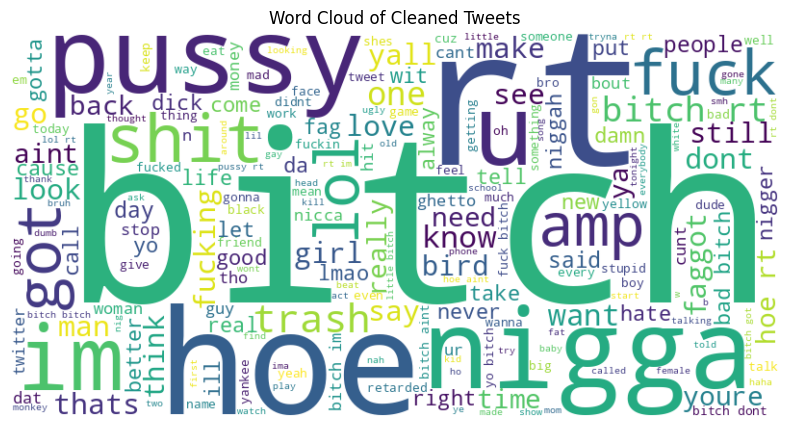

In [ ]:
all_words = " ".join(df['clean_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Cleaned Tweets")
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from sklearn.preprocessing import LabelEncoder

# Encode labels
label_encoder = LabelEncoder()
df['encoded_label'] = label_encoder.fit_transform(df['label'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['encoded_label'], test_size=0.2, random_state=42)

# Tokenize
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding (95th percentile to avoid excessive length)
max_len = int(np.percentile([len(seq) for seq in X_train_seq], 95))
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')


# Model Building

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping

**Simple RNN with Trainable Embedding**

In [ ]:
model_rnn = Sequential()
model_rnn.add(Embedding(input_dim=vocab_size, output_dim=50, input_length=X_train_pad.shape[1]))
model_rnn.add(SimpleRNN(64, return_sequences=False))
model_rnn.add(Dense(32, activation='relu'))
model_rnn.add(Dropout(0.5))
model_rnn.add(Dense(len(label_encoder.classes_), activation='softmax'))  # Use softmax for multi-class

model_rnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


**LSTM with Trainable Embedding**

In [ ]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=vocab_size, output_dim=50, input_length=X_train_pad.shape[1]))
model_lstm.add(LSTM(64, return_sequences=False))
model_lstm.add(Dense(32, activation='relu'))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(len(label_encoder.classes_), activation='softmax'))

model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

**LSTM with Pretrained Word2Vec (GloVe)**

In [ ]:
!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip
!unzip -q glove.twitter.27B.zip

--2025-05-09 05:19:18--  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.twitter.27B.zip [following]
--2025-05-09 05:19:18--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2025-05-09 05:19:18--  https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [ap

In [ ]:
embedding_index = {}
with open("glove.twitter.27B.100d.txt", encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

print(f"Loaded {len(embedding_index)} word vectors from GloVe Twitter.")

Loaded 1193514 word vectors from GloVe Twitter.


In [ ]:
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [ ]:
model_lstm_pretrained = Sequential()
model_lstm_pretrained.add(Embedding(input_dim=vocab_size,
                                    output_dim=embedding_dim,
                                    weights=[embedding_matrix],
                                    input_length=X_train_pad.shape[1],
                                    trainable=False))
model_lstm_pretrained.add(LSTM(64))
model_lstm_pretrained.add(Dense(32, activation='relu'))
model_lstm_pretrained.add(Dropout(0.5))
model_lstm_pretrained.add(Dense(len(label_encoder.classes_), activation='softmax'))

model_lstm_pretrained.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model Training and Evaluation

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Helper function to train and plot history
def train_and_plot(model, name):
    history = model.fit(X_train_pad, y_train,
                        epochs=10,
                        validation_split=0.2,
                        callbacks=[early_stop],
                        batch_size=32,
                        verbose=2)

    # Plotting
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{name} Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{name} Loss')
    plt.legend()

    plt.show()

    return history

**Simple RNN**

Epoch 1/10
496/496 - 10s - 20ms/step - accuracy: 0.8434 - loss: 0.4723 - val_accuracy: 0.8971 - val_loss: 0.3208
Epoch 2/10
496/496 - 2s - 4ms/step - accuracy: 0.9127 - loss: 0.2835 - val_accuracy: 0.8873 - val_loss: 0.3124
Epoch 3/10
496/496 - 2s - 4ms/step - accuracy: 0.9449 - loss: 0.1831 - val_accuracy: 0.8817 - val_loss: 0.3910
Epoch 4/10
496/496 - 3s - 6ms/step - accuracy: 0.9629 - loss: 0.1182 - val_accuracy: 0.8636 - val_loss: 0.4435
Epoch 5/10
496/496 - 3s - 5ms/step - accuracy: 0.9764 - loss: 0.0786 - val_accuracy: 0.8840 - val_loss: 0.5635


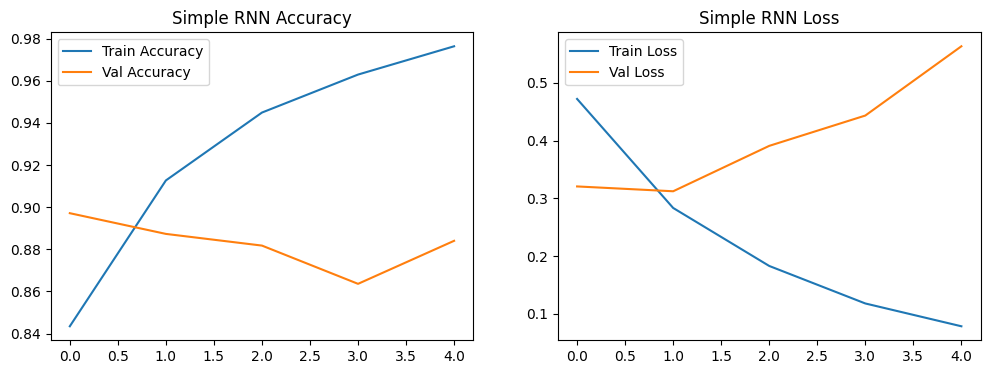

In [ ]:
history_rnn = train_and_plot(model_rnn, "Simple RNN")

**LSTM**

Epoch 1/10
496/496 - 9s - 19ms/step - accuracy: 0.8496 - loss: 0.4578 - val_accuracy: 0.8976 - val_loss: 0.3040
Epoch 2/10
496/496 - 7s - 14ms/step - accuracy: 0.9115 - loss: 0.2861 - val_accuracy: 0.8999 - val_loss: 0.3002
Epoch 3/10
496/496 - 5s - 11ms/step - accuracy: 0.9305 - loss: 0.2114 - val_accuracy: 0.8996 - val_loss: 0.3358
Epoch 4/10
496/496 - 3s - 6ms/step - accuracy: 0.9492 - loss: 0.1603 - val_accuracy: 0.8941 - val_loss: 0.3607
Epoch 5/10
496/496 - 5s - 10ms/step - accuracy: 0.9602 - loss: 0.1242 - val_accuracy: 0.8860 - val_loss: 0.4702


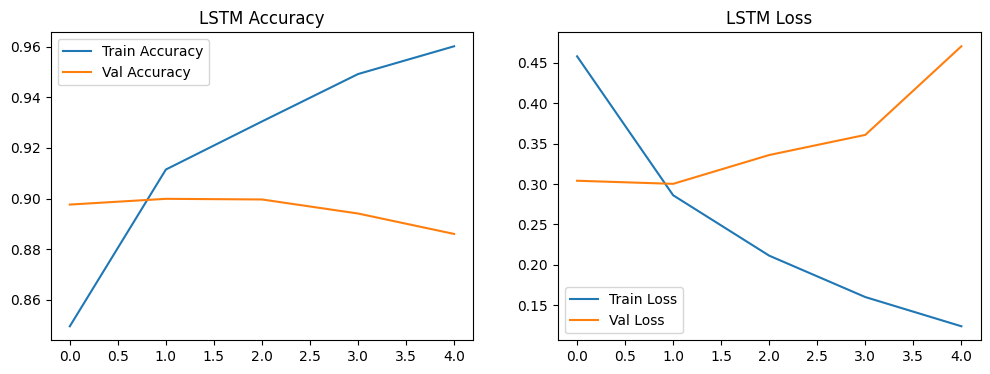

In [ ]:
history_lstm = train_and_plot(model_lstm, "LSTM")

**LSTM with GloVe Twitter**

Epoch 1/10
496/496 - 5s - 10ms/step - accuracy: 0.8697 - loss: 0.4102 - val_accuracy: 0.9009 - val_loss: 0.2940
Epoch 2/10
496/496 - 6s - 11ms/step - accuracy: 0.8918 - loss: 0.3112 - val_accuracy: 0.9049 - val_loss: 0.2730
Epoch 3/10
496/496 - 3s - 6ms/step - accuracy: 0.9005 - loss: 0.2803 - val_accuracy: 0.9019 - val_loss: 0.2729
Epoch 4/10
496/496 - 3s - 6ms/step - accuracy: 0.9051 - loss: 0.2684 - val_accuracy: 0.9002 - val_loss: 0.2931
Epoch 5/10
496/496 - 3s - 6ms/step - accuracy: 0.9102 - loss: 0.2544 - val_accuracy: 0.9125 - val_loss: 0.2503
Epoch 6/10
496/496 - 4s - 7ms/step - accuracy: 0.9155 - loss: 0.2376 - val_accuracy: 0.9017 - val_loss: 0.2796
Epoch 7/10
496/496 - 5s - 9ms/step - accuracy: 0.9180 - loss: 0.2296 - val_accuracy: 0.9095 - val_loss: 0.2647
Epoch 8/10
496/496 - 3s - 6ms/step - accuracy: 0.9226 - loss: 0.2137 - val_accuracy: 0.9072 - val_loss: 0.2941


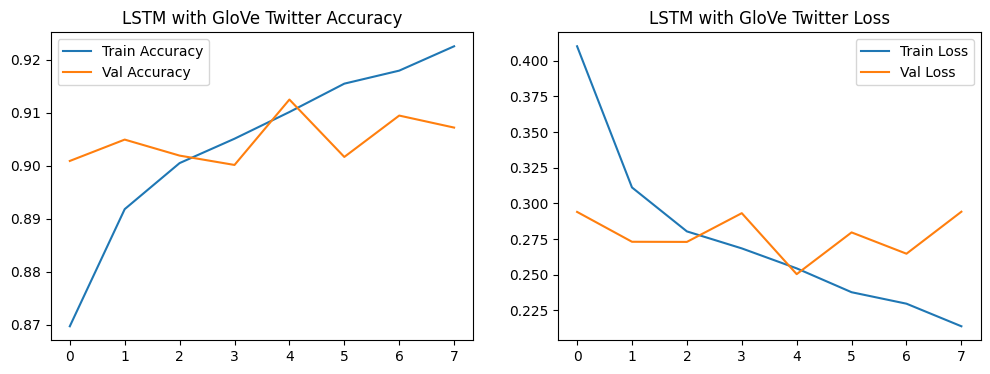

In [ ]:
history_pretrained = train_and_plot(model_lstm_pretrained, "LSTM with GloVe Twitter")

**Evaluation**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

def evaluate_model(model, name):
    y_pred = model.predict(X_test_pad)
    y_pred_classes = np.argmax(y_pred, axis=1)

    print(f"Classification Report for {name}")
    print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'{name} Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    print(f"Accuracy: {accuracy_score(y_test, y_pred_classes):.4f}")


155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Classification Report for Simple RNN
                    precision    recall  f1-score   support

        hate speec       0.38      0.26      0.31       290
           neither       0.81      0.76      0.78       835
offensive language       0.91      0.94      0.93      3832

          accuracy                           0.87      4957
         macro avg       0.70      0.65      0.67      4957
      weighted avg       0.86      0.87      0.87      4957



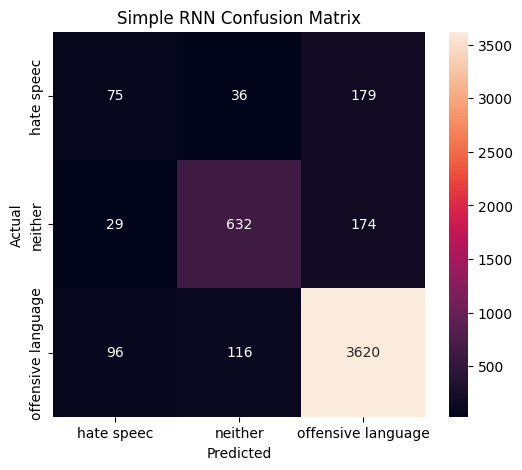

Accuracy: 0.8729


In [ ]:
evaluate_model(model_rnn, "Simple RNN")

155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Classification Report for LSTM
                    precision    recall  f1-score   support

        hate speec       0.75      0.01      0.02       290
           neither       0.79      0.84      0.82       835
offensive language       0.91      0.96      0.93      3832

          accuracy                           0.89      4957
         macro avg       0.82      0.61      0.59      4957
      weighted avg       0.88      0.89      0.86      4957



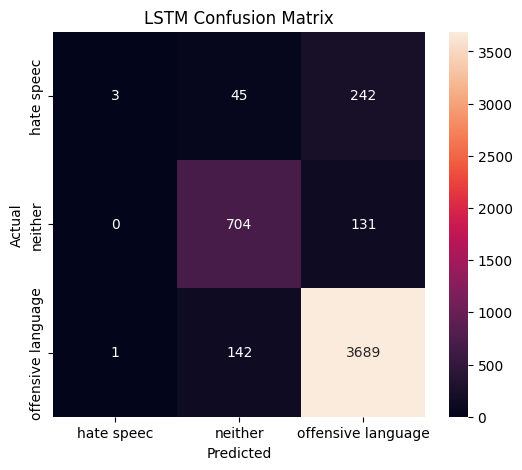

Accuracy: 0.8868


In [ ]:
evaluate_model(model_lstm, "LSTM")

155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Classification Report for LSTM with GloVe Twitter
                    precision    recall  f1-score   support

        hate speec       0.49      0.10      0.16       290
           neither       0.82      0.87      0.85       835
offensive language       0.92      0.96      0.94      3832

          accuracy                           0.90      4957
         macro avg       0.74      0.64      0.65      4957
      weighted avg       0.88      0.90      0.88      4957



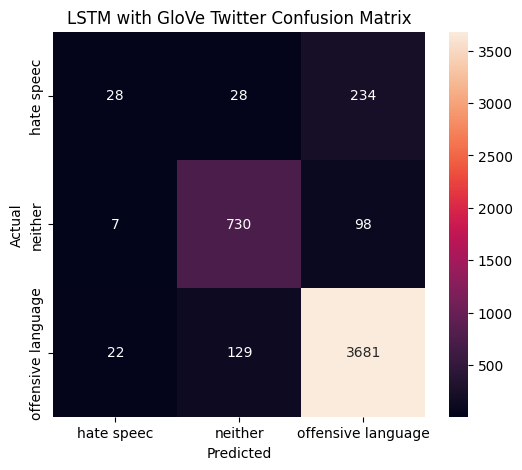

Accuracy: 0.8955


In [ ]:
evaluate_model(model_lstm_pretrained, "LSTM with GloVe Twitter")

**Observation**: Comparing the three model performance, Simple RNN was faster to train due to its few parameters. LSTM model had strong precision with minority class (hatespeech) comparing to other two models. LSTM with embedding model converged better with less overfitting compared to simpleRNN and LSTM model. Overall, all three models were unable to provide a high and accurate performance on hate speech class, this may be due to the high imbalance of the data provided.

# Real-Time GUI with Gradio

In [ ]:
!pip install gradio --quiet
import gradio as gr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 95.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.0 MB/s eta 0:00:00


In [ ]:
def preprocess_input(text):
    text = clean_text(text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

In [ ]:
def classify_tweet(text):
    processed = preprocess_input(text)
    seq = tokenizer.texts_to_sequences([processed])
    padded = pad_sequences(seq, maxlen=X_train_pad.shape[1], padding='post', truncating='post')
    prediction = model_lstm_pretrained.predict(padded)
    class_idx = np.argmax(prediction, axis=1)[0]
    return label_encoder.classes_[class_idx]


In [ ]:
import gradio as gr

interface = gr.Interface(
    fn=classify_tweet,
    inputs=gr.Textbox(lines=2, placeholder="Enter a tweet..."),
    outputs="text",
    title="Tweet Sentiment Classifier",
    description="Classify tweets using an LSTM model with pretrained GloVe Twitter embeddings."
)

interface.launch(share=True)  # Set share=False if you don't need a public link


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://572f726f45f03b52e4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
